<a href="https://colab.research.google.com/github/tozanni/bourbaki_deeplearning/blob/main/Deteccion_de_objectos_con_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteccion de objetos con SSD


**SSD en Pytorch, repositorio original**

https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection


**Código y datos para montar en Drive**

https://drive.google.com/drive/folders/1w7m2lZB3vlUX0HbMhfYTO5RdkMSUTaPT?usp=sharing

**Importar código desde drive con sys.append**

Agregamos el path de codigo al syspath para poder invocar codigo Python desde el folder de Drive


In [17]:
import sys
sys.path.append('/content/drive/MyDrive/Demo_SSD/modules/')
from utils import *
from datasets import PascalVOCDataset

#Ojo, se necesita cargar la clase del modelo para poder usarlo para evaluacion o deteccion
from model import SSD300, MultiBoxLoss


## Evaluacion de modelo de deteccion de objetos

Cargamos modelo serializado y ejecutamos la evaluacion

In [2]:
from tqdm import tqdm
from pprint import PrettyPrinter

# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

# Parameters
data_folder = '/content/drive/MyDrive/Demo_SSD/'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Original
checkpoint = '/content/drive/MyDrive/Demo_SSD/checkpoint_ssd300_orig.pth.tar'

#Entrenamiento EHR
#checkpoint = '/content/drive/MyDrive/Demo_SSD/checkpoint_ssd300.pth.tar'


# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)


def evaluate(test_loader, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)



/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is go

In [3]:
evaluate(test_loader, model)

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/content/drive/MyDrive/Demo_SSD/modules/model.py:501: UserWarning: indexing with dtype tor

{'aeroplane': 0.7887580990791321,
 'bicycle': 0.8351995348930359,
 'bird': 0.7623348236083984,
 'boat': 0.7218425273895264,
 'bottle': 0.45978495478630066,
 'bus': 0.8705356121063232,
 'car': 0.8655831217765808,
 'cat': 0.8828985095024109,
 'chair': 0.5917483568191528,
 'cow': 0.8255912661552429,
 'diningtable': 0.756867527961731,
 'dog': 0.856262743473053,
 'horse': 0.8778411149978638,
 'motorbike': 0.8316892385482788,
 'person': 0.7884440422058105,
 'pottedplant': 0.5071538090705872,
 'sheep': 0.7936667799949646,
 'sofa': 0.7998116612434387,
 'train': 0.8655905723571777,
 'tvmonitor': 0.7492395043373108}

Mean Average Precision (mAP): 0.772


In [24]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)

    #Fix para colab
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

In [13]:
img_path = '/content/drive/MyDrive/Demo_SSD/VOC2007/JPEGImages/000001.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

/content/drive/MyDrive/Demo_SSD/modules/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/MyDrive/Demo_SSD/modules/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


/content/drive/MyDrive/Demo_SSD/modules/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/MyDrive/Demo_SSD/modules/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


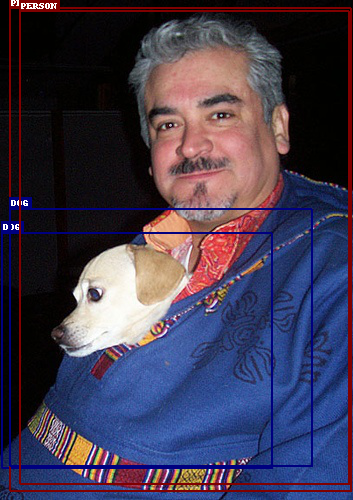

In [16]:
detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)

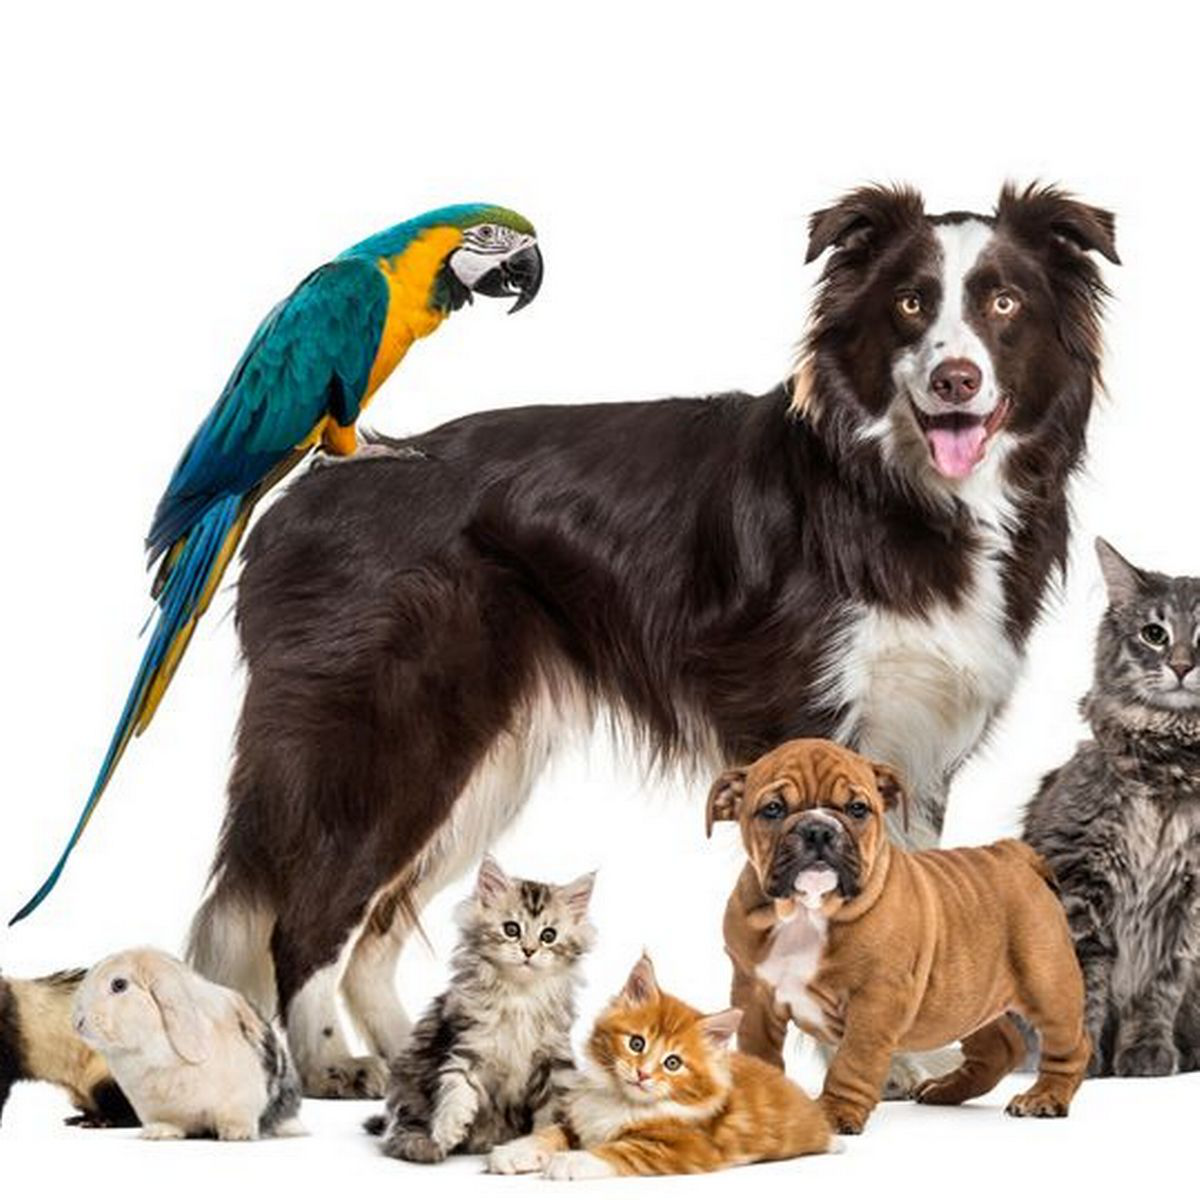

In [22]:
url = '/content/drive/MyDrive/Demo_SSD/tests/2_Precious_Pets_2-1.jpeg'
original_image = Image.open(url, mode='r')
original_image = original_image.convert('RGB')
original_image

/content/drive/MyDrive/Demo_SSD/modules/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/MyDrive/Demo_SSD/modules/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


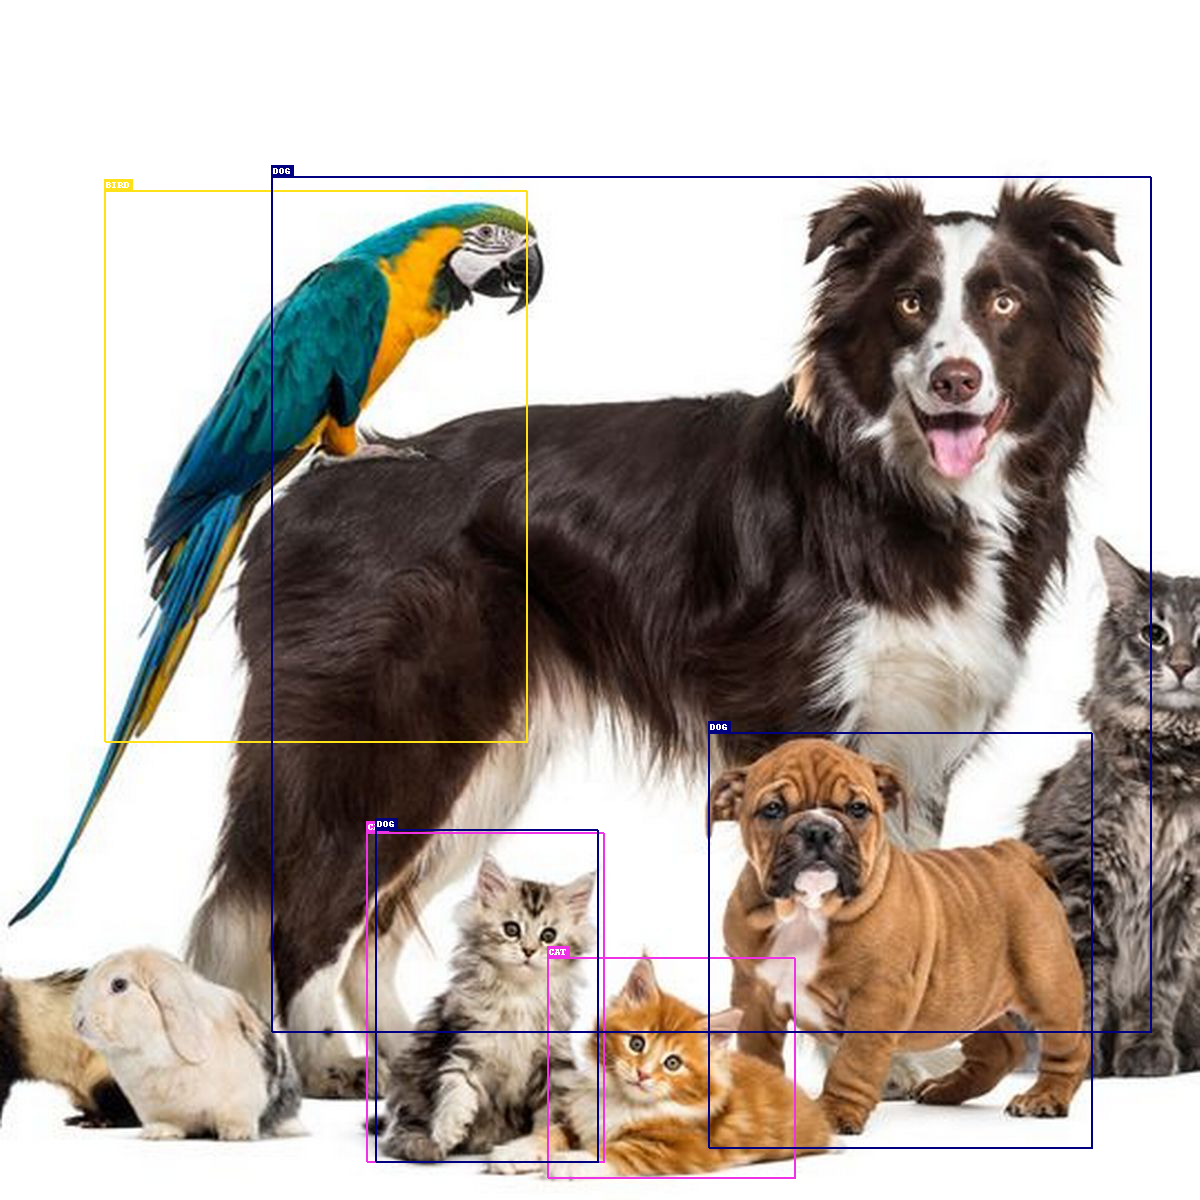

In [25]:
detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)